# IPA to IMAGE model

## Prerequisites

In principle, this should work on a computer without a GPU. It will help if you have a lot of RAM.

- Pull latest changes from https://github.com/gchrupala/reimaginet
- Download http://grzegorz.chrupala.me/data/coco.zip and unzip it in the `reimaginet/data/coco directory`.
  You should have the following files:
  
  - `dataset.json` - MSCOCO sentences
  - `vgg_feats.mat` - MSCOCO image vectors
  - `dataset.ipa.jsonl.gz`  - IPA transcriptions of MSCOCO sentences

- Download http://grzegorz.chrupala.me/data/model-ipa.zip and put it in the examples directory (same as this notebook)

In [1]:
import imaginet.task

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K20m


## Load the model

(It will take a couple of minutes)

In [2]:
model = imaginet.task.load(path="model-ipa.zip")

KeyError: "There is no item named 'maker.pkl' in the archive"

## Symbol embeddings

In [3]:
emb = imaginet.task.embeddings(model)
print(emb.shape)

(49, 256)


The table of IPA symbols corresponding to  the 49 dimensions 

In [5]:
symb = imaginet.task.symbols(model)
print " ".join(symb.values())

<BEG> <END> <UNK> t ˈ u ː k æ s l e ɪ ŋ ə ɡ ˌ ɛ ð ɚ ɹ ɑ n p o ʊ z v a ʃ ɐ m ᵻ d i f j b ɔ h w ʒ ʌ ɾ θ ɜ ̃ r ʲ


Let's display the embeddings projected to 2D via PCA

In [7]:
%pylab inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xy = pca.fit_transform(emb)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


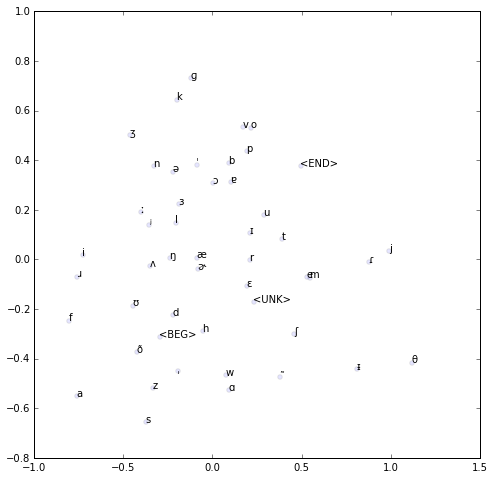

In [8]:
pylab.rc('font', family='DejaVu Sans')
pylab.figure(figsize=(8,8))
pylab.scatter(xy[:,0], xy[:,1], alpha=0.1)
for j,symb_j in symb.items():
    pylab.text(xy[j,0], xy[j,1], symb_j)

Seems mostly random...

## Load MSCOCO validation data

In [9]:
from imaginet.data_provider import getDataProvider
# Adjust the root to point to the directory above data
prov = getDataProvider('coco', root="..")

In [10]:
sents = list(prov.iterSentences(split='val'))

In [11]:
from imaginet.simple_data import phonemes
sents_ipa = [ phonemes(sent) for sent in sents ]

## Project sentences to state space

In [12]:
reps = imaginet.task.representation(model, sents_ipa)

## Find similar sentences in state space

Compute the pairwise cosine distance matrix.

In [13]:
from scipy.spatial.distance import cdist
distance = cdist(reps, reps, metric='cosine')

### Display neighbors for a sentence

In [14]:
import numpy
def neighbors(k, distance=distance):
    nn =  numpy.argsort(distance[k,:])[1:5]
    print sents[k]['raw'], ''.join(sents_ipa[k])
    for n in nn:
        print u"✔" if sents[n]['imgid']==sents[k]['imgid'] else u"✘", \
        sents[n]['raw'], ''.join(sents_ipa[n])

In [15]:
import random

In [16]:
for _ in range(10):
    neighbors(random.randint(0, len(sents)))
    print

Man dishing out pizza onto a plate held by another person. mˈændˈɪʃɪŋˈaʊtpˈiːtsəˌɑːntʊɐplˈeɪthˈɛldbaɪɐnˈʌðɚpˈɜːsən
✔ A man placing pizza on a plate through an opening. ɐmˈænplˈeɪsɪŋpˈiːtsəˌɑːnɐplˈeɪtθɹuːɐnˈoʊpənɪŋ
✘ a man decorating a pizza on the table ɐmˈændˈɛkoːɹˌeɪɾɪŋɐpˈiːtsəɑːnðətˈeɪbəl
✘ a man is cutting a pizza on a table ɐmˈænɪzkˈʌɾɪŋɐpˈiːtsəˌɑːnɐtˈeɪbəl
✘ Guys looking at contents of a pizza with glasses. ɡˈaɪzlˈʊkɪŋætkˈɑːntɛntsəvəpˈiːtsəwɪðɡlˈæsᵻz

A cook preparing fresh pizza in a kitchen. ɐkˈʊkpɹɪpˈɛɹɹɪŋfɹˈɛʃpˈiːtsəɪnɐkˈɪtʃən
✘ a man working on a pizza in a kitchen ɐmˈænwˈɜːkɪŋˌɑːnɐpˈiːtsəɪnɐkˈɪtʃən
✘ A man preparing a pizza inside of a kitchen. ɐmˈænpɹɪpˈɛɹɹɪŋɐpˈiːtsəɪnsˈaɪdəvəkˈɪtʃən
✘ A man standing in a kitchen preparing a pizza. ɐmˈænstˈændɪŋɪnɐkˈɪtʃənpɹɪpˈɛɹɹɪŋɐpˈiːtsə
✘ Man working in a restaurant kitchen cutting a pizza. mˈænwˈɜːkɪŋɪnɐɹˈɛstɹɑːntkˈɪtʃənkˈʌɾɪŋɐpˈiːtsə

A person with a toothbrush in their mouth with a baby. ɐpˈɜːsənwɪðɐtˈuːθbɹʌʃɪnðɛɹmˈaʊθwɪðɐbˈeɪbi
✘ A 

## Tracing the evolution of states

In [17]:
import imaginet.tracer
reload(imaginet.tracer)

<module 'imaginet.tracer' from '/exp2/gchrupala/repos/reimaginet/imaginet/tracer.pyc'>

In [18]:
tr = imaginet.tracer.Tracer()

In [19]:
tr.fit(reps)

Embedding
Fitting PCA


In [20]:
tr.proj.explained_variance_

array([ 16.707798 ,  12.0665617], dtype=float32)

## Use espeak to convert graphemes to phonemes

In [21]:
from subprocess import check_output
def espeak(words):
    return phon(check_output(["espeak", "-q", "--ipa",
                        '-v', 'en-us',
                        words]).decode('utf-8'))
def phon(inp):
    return list(''.join(inp.split()))

In [22]:
def trace(orths, tracer=tr, model=model, eos=True, size=(6,6)):
    ipas = [ espeak(orth) for orth in orths ]
    states = [ imaginet.task.states(model, ipa) for ipa in ipas ]
    pylab.figure(figsize=size)
    tracer.traces(ipas, states, eos=eos)

## Plot traces of example sentences

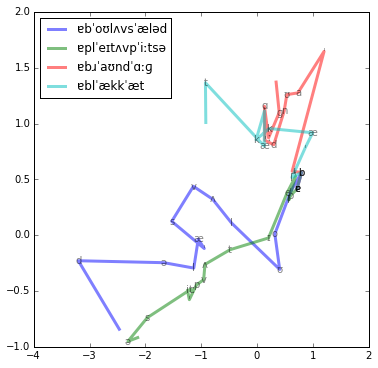

In [23]:
trace(["A bowl of salad","A plate of pizza","A brown dog", "A black cat"])

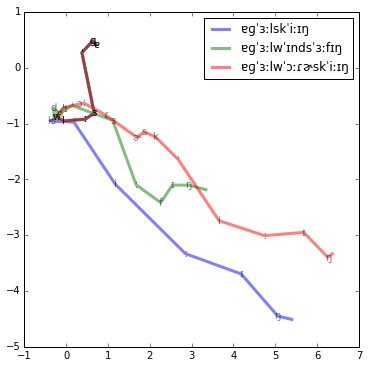

In [24]:
trace(["a girl skiing", "a girl wind surfing", "a girl water skiing",])

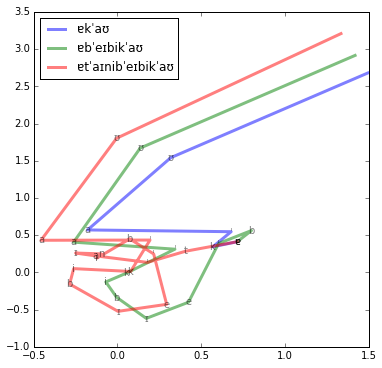

In [25]:
trace(["a cow", "a baby cow","a tiny baby cow"])

(-5.0, 1.0, -1.0, 0.60000000000000009)

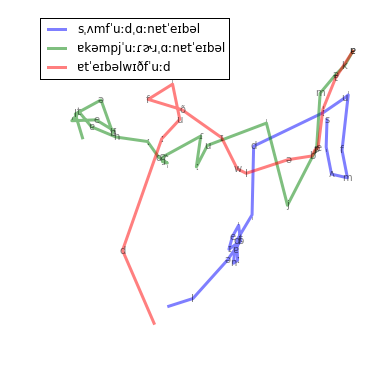

In [26]:
trace(["some food on a table","a computer on a table","a table with food"])
pylab.axis('off')

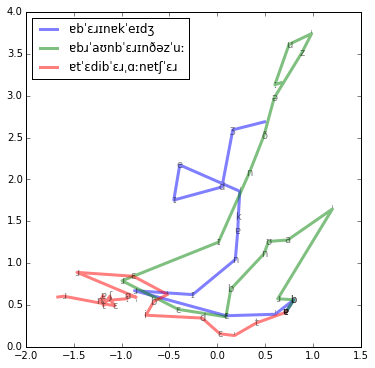

In [42]:
trace(["a bear in a cage", "a brown bear in the zoo","a teddy bear on a chair"])